In [1]:
import keras 
keras.__version__

Using TensorFlow backend.


'2.1.1'

# Neural Style Transfer

Neural style transfer, introduced by <a href='https://arxiv.org/abs/1508.06576'>Leon Gatys et al.</a> in the summer of 2015, consists of applying the style of a reference image to a target image while conserving the content of the target image. The figure below, taken from the original paper, illustrates how *style* from one image is applied to the *content* of another. 

<img src='images/img_0.png' style='width:50%' />

*Style* essentially means textures, colors, and visual patterns in the image while *content* is the higher-level macrostructure of the image. For instance, blue-and-yellow circular brushstrokes are considered to be the style in figure the bottom lefts image (using Starry Night by Vincent Van Gogh) which are applied fo the content image (houses along a canal.

The core idea of neural style transfer is to define a loss function (which our network will try to minimise) that measures the *style* distance of the generated image with respect to the designated *style* image and *content* distance of the generated image with respect to the designated *content* image.   

Activations from lower layers in a network contain local information about the image, whereas activations in higher layers contain increasingly global, abstract information. Therefore it is such that we select layers appropriate to describe the style and layers appropriate to describe the content then measure the difference of each of these of the generated image to determine the networks loss. 

## Performing Neural Style Transfer 

### Introducing VGGNet (Classification)

In [94]:
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K

We will be borrowing the weights (and therefore encoded abstraction representationed) from a pre-trained model that was trained on over 10 million images from the labeled dataset ImageNet. Here we will be using VGG16 (other architectures shown below - 16 refers to the use of 16 layers) to extract features of our *style* and *content* image.

It was frist introduced as one of the contenders in 2014’s ImageNet Challenge and secured the first and second place in the localisation and classification tracks respectively. VGGNets are favoured due their simplistic design;  a family of models essentially composed of simple (3×3) convolutional filters with increasing depth (11–19 layers) managed to perform so well at a range of computer vision tasks.

You can learn more about the VGG model from the original paper <a href='
Very Deep Convolutional Networks for Large-Scale Image Recognition'>Very Deep Convolutional Networks for Large-Scale Image Recognition by Karen Simonyan and Andrew Zisserman</a>. 

#### VGG Architectures

<img src='images/vgg_architectures.jpg' style='width:50%' />

In [95]:
vgg16_model = VGG16(weights='imagenet', include_top=True)

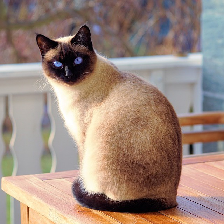

In [96]:
img_path = 'data/cat.jpg'
img = Image.open(img_path)

# Get dimensions
img_width, img_height = img.size

# Crop
target_width = min(img_width, img_height)
target_height = min(img_width, img_height)

left = (img_width - target_width)/2
top = (img_height - target_height)/2
right = (img_width + target_width)/2
bottom = (img_height + target_height)/2

img.crop((left, top, right, bottom))

# Resize 
img = img.resize((224,224)) 

# Show
img

In [97]:
# Preprocess image 

# 1. Convert it into an array
x = np.asarray(img, dtype='float32')
# 2. Convert it into a list of arrays
x = np.expand_dims(x, axis=0)
# 3. Pre-process the input to match the training data
x = preprocess_input(x)

In [98]:
# Make a prediction using our model 

preds = vgg16_model.predict(x)
print('Predictions:')
for _, label, prob in decode_predictions(preds, top=10)[0]:
    print("{} {}%".format(label, round(100.0 * prob,2)))

Predictions:
Siamese_cat 99.85%
Egyptian_cat 0.13%
lynx 0.01%
cougar 0.0%
paper_towel 0.0%
tabby 0.0%
bookcase 0.0%
bulbul 0.0%
pitcher 0.0%
dough 0.0%


## Neural Style Transfer

In [99]:
import time
from PIL import Image
import numpy as np

from keras import backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [163]:
target_width = 320
target_height = 320
content_weight = 0.25
style_weight = 0.5
total_variation_weight = 1e-4

### Loading our content and style reference images 

In [164]:
def load_image(img_path, target_size=(target_width, target_height)):
    """
    
    """
    # Load image 
    img = Image.open(img_path)
    
    # Get dimensions
    img_width, img_height = img.size

    # Crop
    target_width = min(img_width, img_height)
    target_height = min(img_width, img_height)

    left = (img_width - target_width)/2
    top = (img_height - target_height)/2
    right = (img_width + target_width)/2
    bottom = (img_height + target_height)/2

    img.crop((left, top, right, bottom))

    # Resize 
    img = img.resize(target_size)
               
    # Convert to floats 
    img_array = np.asarray(img, dtype='float32')
    # Add another dimension i.e. from (512, 512, 3) to (1,512,512,3) 
    img_array = np.expand_dims(img_array, axis=0)    
    
    """
    Before we proceed much further, we need to transform this input data to match what was done 
    in Simonyan and Zisserman (2015), the paper that introduces the VGG Network model that 
    we’re using. 
    For this, we need to perform two transformations:        
    """
    
    """
    1. Subtract the mean RGB value (computed previously on the ImageNet training set and easily 
       obtainable from Google searches) from each pixel.
    """
    img_array[:, :, :, 0] -= 123.68
    img_array[:, :, :, 1] -= 116.779
    img_array[:, :, :, 2] -= 103.939
    """
    2. Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).
    """
    img_array = img_array[:, :, :, ::-1]
    
    return img_array               
    

In [165]:
content_image_path = 'data/cat.jpg'
# https://en.wikipedia.org/wiki/The_Starry_Night
style_image_path = 'data/Van_Gogh-Starry_Night.jpg'

In [166]:
content_array = load_image(content_image_path)
style_array = load_image(style_image_path)

In [167]:
print("content_array shape {}, style_array shape {}".format(content_array.shape, style_array.shape))

content_array shape (1, 320, 320, 3), style_array shape (1, 320, 320, 3)


In [168]:
"""
Lets now define variables in Keras’ backend (the TensorFlow graph). We also introduce a placeholder 
variable to store the combination image that retains the content of the content image while 
incorporating the style of the style image.
"""
content_image = K.variable(content_array)
style_image = K.variable(style_array)

In [169]:
combination_image = K.placeholder((1, target_width, target_height, 3))
input_tensor = K.concatenate([content_image,
                              style_image,
                              combination_image], axis=0)

### Reuse a model pre-trained for image classification to define loss functions

In [170]:
vgg16_model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [171]:
layers = dict([(layer.name, layer.output) for layer in vgg16_model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_9/Relu:0' shape=(3, 320, 320, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_9/Relu:0' shape=(3, 320, 320, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_9/MaxPool:0' shape=(3, 160, 160, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_9/Relu:0' shape=(3, 160, 160, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_9/Relu:0' shape=(3, 160, 160, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_9/MaxPool:0' shape=(3, 80, 80, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_9/Relu:0' shape=(3, 80, 80, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_9/Relu:0' shape=(3, 80, 80, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_9/Relu:0' shape=(3, 80, 80, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_9/MaxPool:0' shape=(3, 40, 40, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_9/Relu:0' shape=(3, 40, 40, 512) dtype

---

In [172]:
loss = K.variable(0.)

The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

Here we are following Johnson et al. (2016) and use the content feature from *block2_conv2*, because the original choice in Gatys et al. (2015) (*block4_conv2*) loses too much structural detail. 

In [173]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

layer_features = layers['block5_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features, 
                                      combination_features)

For the style loss, we first define something called a Style Matrix (or Gram matrix). The terms of this matrix are covariance between each filter i.e. you can think of this, intutitively, as identlifying correlation between filters which describe the style of the image i.e. if there was a high correlation between horizontally features across all filters then this implies that a dominate style of the image is horizontal features. This is what allows them to capture information about style independent of content.

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.

In [174]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

In [175]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [176]:
feature_layers = ['block1_conv2', 
                  'block2_conv1',
                  'block3_conv1', 
                  'block4_conv1',
                  'block5_conv1']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

To encourage spatial smoothness (and therefore remove some of the noise) we introduce another term called total variation loss (a regularisation term). 

In [177]:
def total_variation_loss(x):
    a = K.square(x[:, :target_height-1, :target_width-1, :] - x[:, 1:, :target_width-1, :])
    b = K.square(x[:, :target_height-1, :target_width-1, :] - x[:, :target_height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

--- 

Our last task is to define the gradients of the total loss relative to the combination image (content and style) and use these gradients to iteratively improve loss upon our combination image to minimise loss. 

In [178]:
# Get the gradients of the generated image with respect to the loss 
grads = K.gradients(loss, combination_image)[0] 

In [179]:
# Fetch the current loss and current graidents 
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

In [180]:
# def eval_loss_and_grads(x):
#     x = x.reshape((1, target_height, target_width, 3))
#     outs = f_outputs([x])
#     loss_value = outs[0]
#     grad_values = outs[1].flatten().astype('float64')
#     return loss_value, grad_values

In [181]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, target_height, target_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

We are now ready to solve our optimisation problem; this combination image (aka generated image) beings as a set of randomly generated numbers (noise) and use the L-BFGS algorithm (a quasi-Newton algorithm that’s significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

In [182]:
iterations = 10

x = np.random.uniform(0, 255, (1, target_height, target_width, 3)) - 128.
x = preprocess_input(x) 
x = x.flatten()

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, 
                                     x,
                                     fprime=evaluator.grads, 
                                     maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 7.00495e+07
Iteration 0 completed in 137s
Start of iteration 1
Current loss value: 2.89451e+07
Iteration 1 completed in 143s
Start of iteration 2
Current loss value: 2.02712e+07
Iteration 2 completed in 140s
Start of iteration 3
Current loss value: 1.67528e+07
Iteration 3 completed in 133s
Start of iteration 4
Current loss value: 1.42815e+07
Iteration 4 completed in 130s
Start of iteration 5
Current loss value: 1.25894e+07
Iteration 5 completed in 131s
Start of iteration 6
Current loss value: 1.13244e+07
Iteration 6 completed in 131s
Start of iteration 7
Current loss value: 1.02299e+07
Iteration 7 completed in 140s
Start of iteration 8
Current loss value: 9.37455e+06
Iteration 8 completed in 142s
Start of iteration 9
Current loss value: 8.57619e+06
Iteration 9 completed in 142s


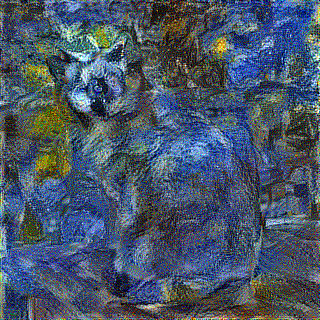

In [183]:
x = x.reshape((target_height, target_width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 123.68
x[:, :, 1] += 116.779
x[:, :, 2] += 103.939
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)